In [1]:
import numpy as np
import pandas as pd
from JAAEC import AmazingAutoEncoder
import torch
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import data
import tdt

In [2]:
# Load data
data_path = "/home/bugsie/PycharmProjects/FiberPhotometryAnalyzer/data/fiber1/test/D2-84_veh_30-45min"
block = tdt.read_block(data_path)

/tmp/ipykernel_12928/3010589469.py:3: Warning: tnt file could not be processed
  block = tdt.read_block(data_path)


read from t=0s to t=918.23s


In [3]:
# Load model
model = AmazingAutoEncoder.load_from_checkpoint("/home/bugsie/PycharmProjects/FiberPhotometryAnalyzer/epoch=34-step=314687.ckpt")

In [4]:
# Process data
data = block["streams"]["LMag"]["data"][0]
data = (data - data.mean()) / data.std()
windowed_data = torch.tensor(data).unfold(0, 1000, 10).unsqueeze(2)

In [5]:
# Get time data
fs = block["streams"]["LMag"]["fs"]
time = np.arange(0, len(data) / fs, 1 / fs)
windowed_time = torch.tensor(time).unfold(0, 1000, 10).unsqueeze(2)

In [6]:
# Get latent space
latent_space = []

if os.path.exists("/home/bugsie/PycharmProjects/FiberPhotometryAnalyzer/behaviors/D1 Drug/latent/Animal71.npy"):
    latent_space = np.load("/home/bugsie/PycharmProjects/FiberPhotometryAnalyzer/behaviors/D1 Drug/latent/Animal71.npy")
else:
    for i, batch in enumerate(windowed_data):
        print(batch.shape)
        print(f"Batch {i} of {len(windowed_data)}")
        latent_space.append(model.encoder(batch.cuda()).cpu().detach().numpy())

    # Stack latent space
    latent_space = np.vstack(latent_space)

    # Save latent space
    np.save("latent_space", latent_space)

In [7]:
# Generate correlation matrix for latent space
correlation_matrix = np.corrcoef(latent_space.T)

/tmp/ipykernel_12928/2619113972.py:3: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(correlation_matrix, cmap="hot", interpolation="None")
/tmp/ipykernel_12928/2619113972.py:3: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(correlation_matrix, cmap="hot", interpolation="None")


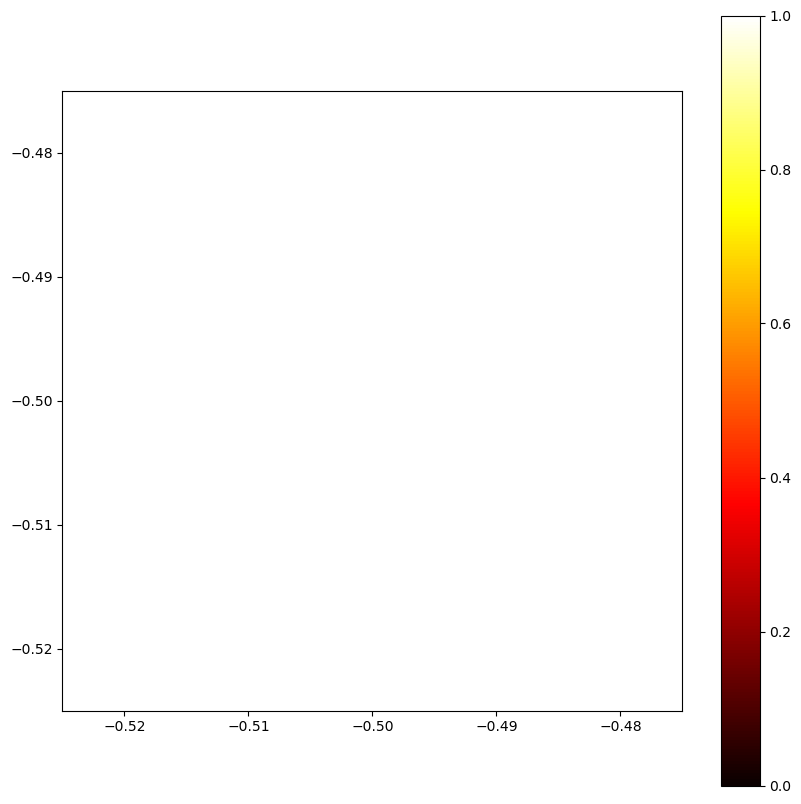

In [8]:
# Plot correlation matrix
plt.figure(figsize=(10, 10))
plt.imshow(correlation_matrix, cmap="hot", interpolation="None")
plt.colorbar()
plt.show()

In [9]:
# Load events csv
events = pd.read_csv(os.path.join(data_path, "/home/bugsie/PycharmProjects/FiberPhotometryAnalyzer/data/D2-84_vehicle_30-45minFP-evts.csv"))

In [10]:
events.drop(columns=["comment"], inplace=True)

In [11]:
events["Time"] = events["Time"] / 1000
events["Duration"] = events["Duration"] / 1000

In [12]:
events

,Time,Duration,TrackName
0,118.233,2.614,rear
1,121.630,6.957,walk
2,129.738,6.260,rear
3,136.908,4.608,walk
4,142.867,18.996,body
...,...,...,...
83,821.987,37.098,walk
84,85.133,4.177,rear
85,859.976,10.063,rest
86,874.898,25.182,walk


In [13]:
# Get event time indexes in latent space
event_times = []
for i, event in events.iterrows():
    event_times.append(np.where((windowed_time[:, 0, 0] > event["Time"]) & (windowed_time[:, 0, 0] < event["Time"] + event["Duration"]))[0])

In [14]:
# Get latent space for events
event_latent_space = []
for event_time in event_times:
    event_latent_space.append(latent_space[event_time[0]:event_time[-1]])

In [15]:
event_latent_space[0].shape

(98, 32)

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
for event in event_latent_space:
    pca.fit(event)
pca.explained_variance_ratio_

array([0.44707453, 0.21815076, 0.12468789, 0.07256879], dtype=float32)

In [17]:
events_names = events["TrackName"].unique().tolist()

In [18]:
events_names

['rear', 'walk', 'body', 'groom', 'rest', 'face']

In [19]:
pca_latent_space = []
for i, event in enumerate(event_latent_space):
    event_pca = pca.transform(event)
    event_pca_with_behavior = []
    for j, point in enumerate(event_pca):
        event_pca_with_behavior.append(np.append(point, events_names.index(events["TrackName"][i])))

    pca_latent_space.append(event_pca_with_behavior)

In [20]:
pca_latent_space = np.vstack(pca_latent_space)

/tmp/ipykernel_25156/2670330722.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


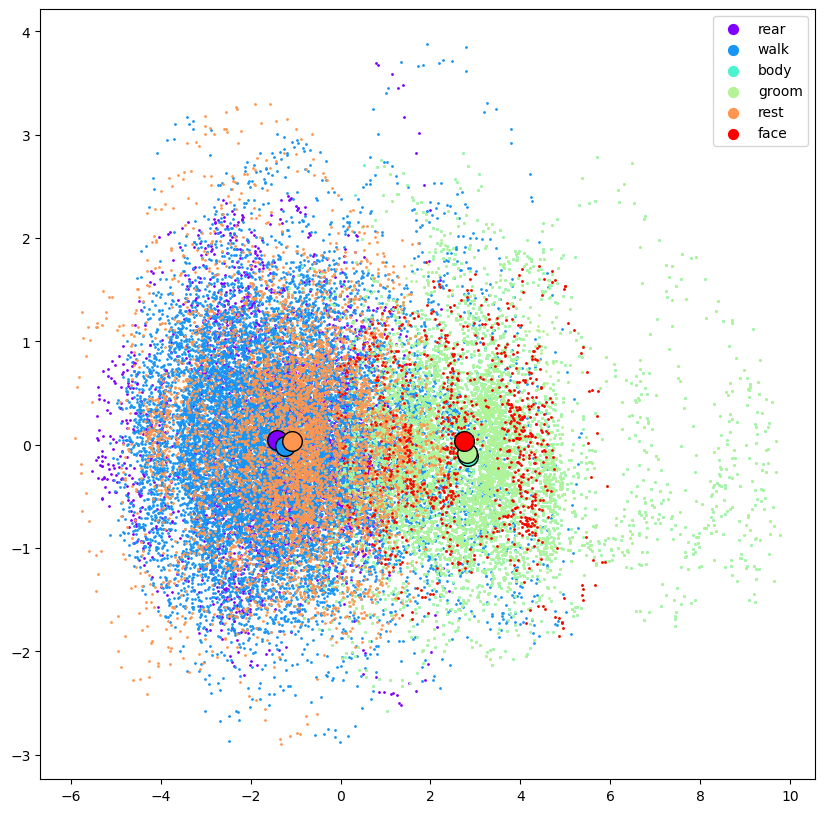

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plt.figure(figsize=(10, 10))

unique_events = np.unique(pca_latent_space[:, 4])
colors = cm.rainbow(np.linspace(0, 1, len(unique_events)))

for i, event in enumerate(unique_events):
    idx = pca_latent_space[:, 4] == event
    x = pca_latent_space[idx, 2]
    y = pca_latent_space[idx, 3]
    plt.scatter(x, y, color=colors[i], label=events_names[int(event)], s=1)

    # Calculate and plot the centroid
    centroid_x = np.mean(x)
    centroid_y = np.mean(y)
    plt.scatter(centroid_x, centroid_y, color=colors[i], marker="o", edgecolor="black", linewidths=1, s=200, zorder=3)

legend = plt.legend()
for handle in legend.legendHandles:
    handle._sizes = [50]  # Set the legend marker size

plt.show()


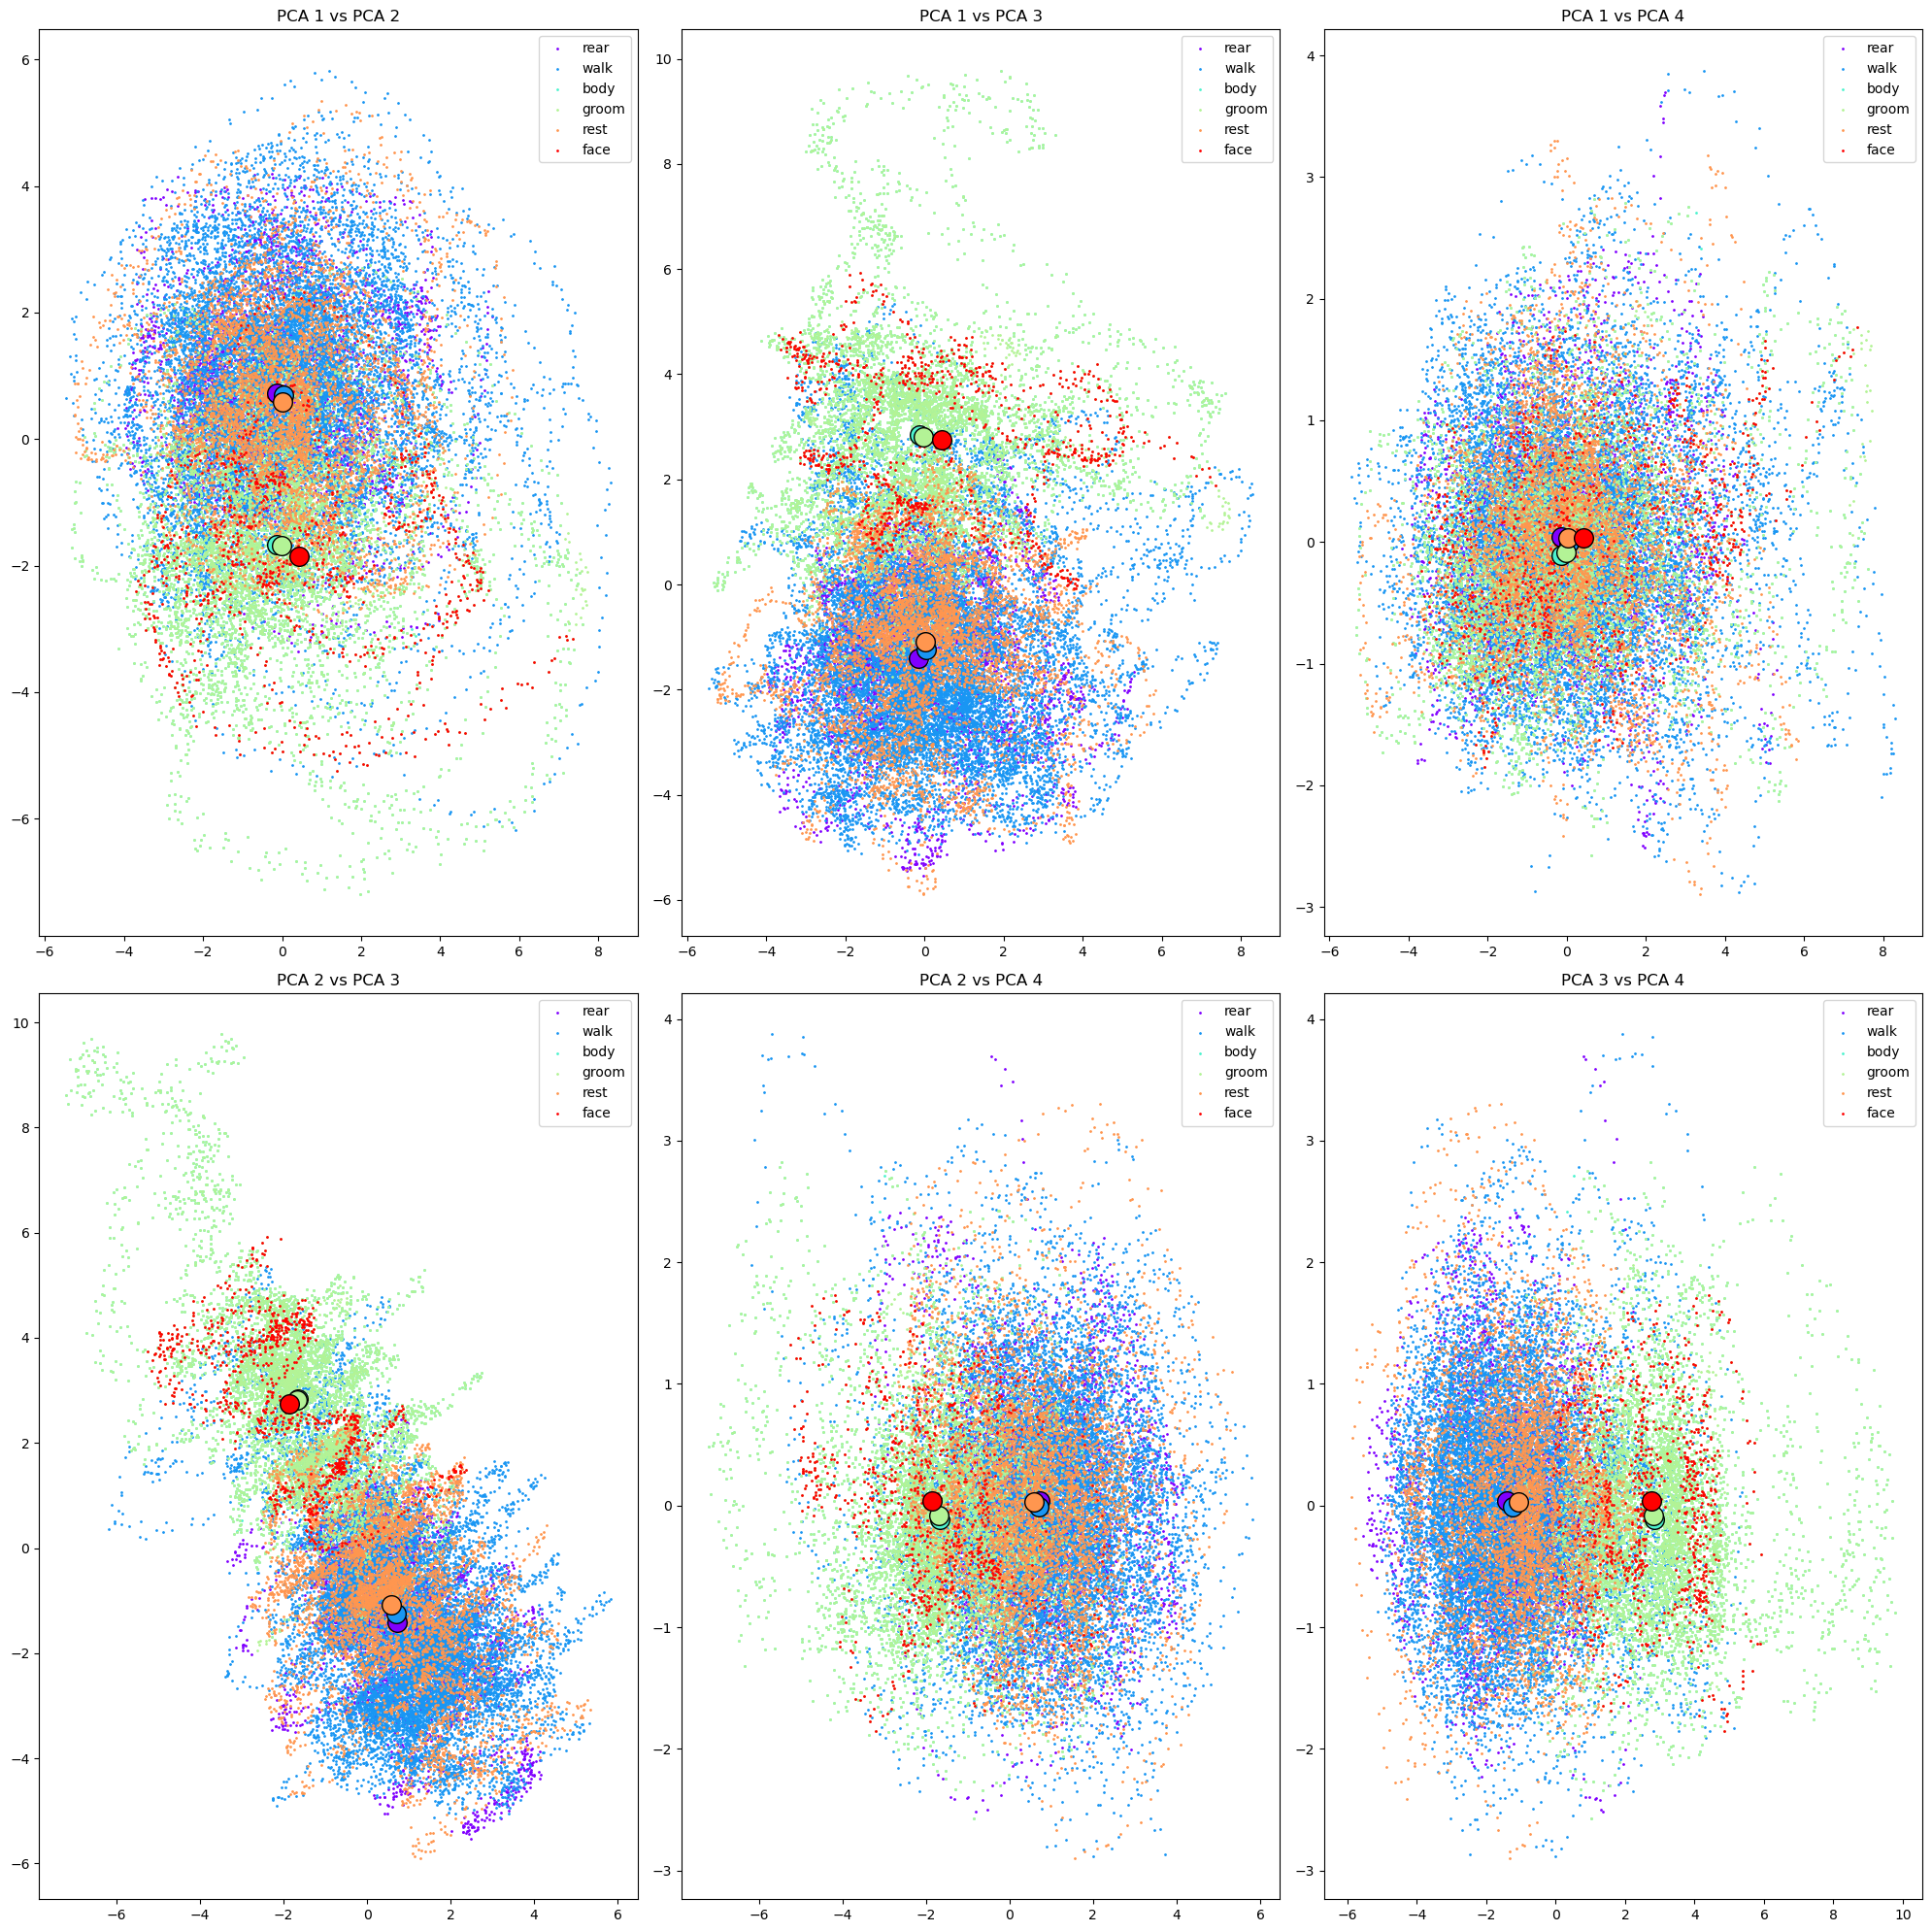

In [22]:
from itertools import combinations
import math

n_components = pca_latent_space.shape[1] - 1  # Exclude the label column
combs = list(combinations(range(n_components), 2))  # Generate all unique combinations of 2 components

# Calculate the number of rows and columns for the subplots
n_plots = len(combs)
n_cols = int(math.ceil(math.sqrt(n_plots)))
n_rows = int(math.ceil(n_plots / n_cols))

fig = plt.figure(figsize=(20, 20))

for idx, (i, j) in enumerate(combs):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)

    unique_events = np.unique(pca_latent_space[:, -1])  # Assuming label is in the last column
    colors = cm.rainbow(np.linspace(0, 1, len(unique_events)))

    for k, event in enumerate(unique_events):
        idx = pca_latent_space[:, -1] == event
        x = pca_latent_space[idx, i]
        y = pca_latent_space[idx, j]

        ax.scatter(x, y, color=colors[k], label=events_names[int(event)], s=1)

        # Calculate and plot the centroid
        centroid_x = np.mean(x)
        centroid_y = np.mean(y)
        ax.scatter(centroid_x, centroid_y, color=colors[k], marker="o", edgecolor="black", linewidths=1, s=200, zorder=3)

    ax.set_title(f'PCA {i + 1} vs PCA {j + 1}')
    ax.legend()

plt.tight_layout()
plt.show()